In [8]:
player_name = '火龙果说电影'
player_num = 4

In [9]:
if player_num == 4:
    base_url = 'https://2.data.amae-koromo.com/api/v2/pl4'
    room_rank = '16.15.12.11.9.8'
    color = {16: 'r', 15: 'r', 12: 'g', 11: 'g', 9: 'y', 8: 'y'}
    initial_rank = 10301
elif player_num == 3:
    base_url = 'https://2.data.amae-koromo.com/api/v2/pl3'
    room_rank = '26.24.22.25.23.21'
    color = {26: 'r', 25: 'r', 24: 'g', 23: 'g', 22: 'y', 21: 'y'}
    initial_rank = 20301
else:
    raise ValueError(f"invalid player_num: {player_num}")

In [10]:
import requests

player = requests.get(f"{base_url}/search_player/{player_name}").json()[0]
print(player)

{'id': 8888621, 'nickname': '火龙果说电影', 'level': {'id': 10403, 'score': 2741, 'delta': 70}, 'latest_timestamp': 1670222602}


In [11]:
end_timestamp = player['latest_timestamp']
records = []

while True:
    pending_records = requests.get(
        f"{base_url}/player_records/{player['id']}/{end_timestamp}999/1262304000000?mode={room_rank}&limit=200&descending=true").json()
    records.extend(pending_records)

    if len(pending_records) < 200:
        break

    end_timestamp = pending_records[-1]["startTime"] - 1

records.reverse()

print(f"got {len(records)} records")

got 3522 records


In [12]:
_major_rank_mapping = ['士', '杰', '豪', '圣', '', '魂']


def map_rank(rank_code: int) -> str:
    return f'{_major_rank_mapping[rank_code // 100 % 100 - 2]}{rank_code % 100}'


_rank_max_pt = {301: 1200, 302: 1400, 303: 2000, 401: 2800, 402: 3200, 403: 3600, 501: 4000, 502: 6000, 503: 9000}


def rank_max_pt(rank_code: int) -> int:
    if rank_code // 100 % 100 >= 6:
        return 10000
    else:
        return _rank_max_pt[rank_code % 1000]

In [13]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_manager.fontManager.addfont("src/nonebot_plugin_majsoul/res/LXGWWenKaiMonoLite-Regular.ttf")
plt.rcParams['font.sans-serif'] = 'LXGW WenKai Mono Lite'

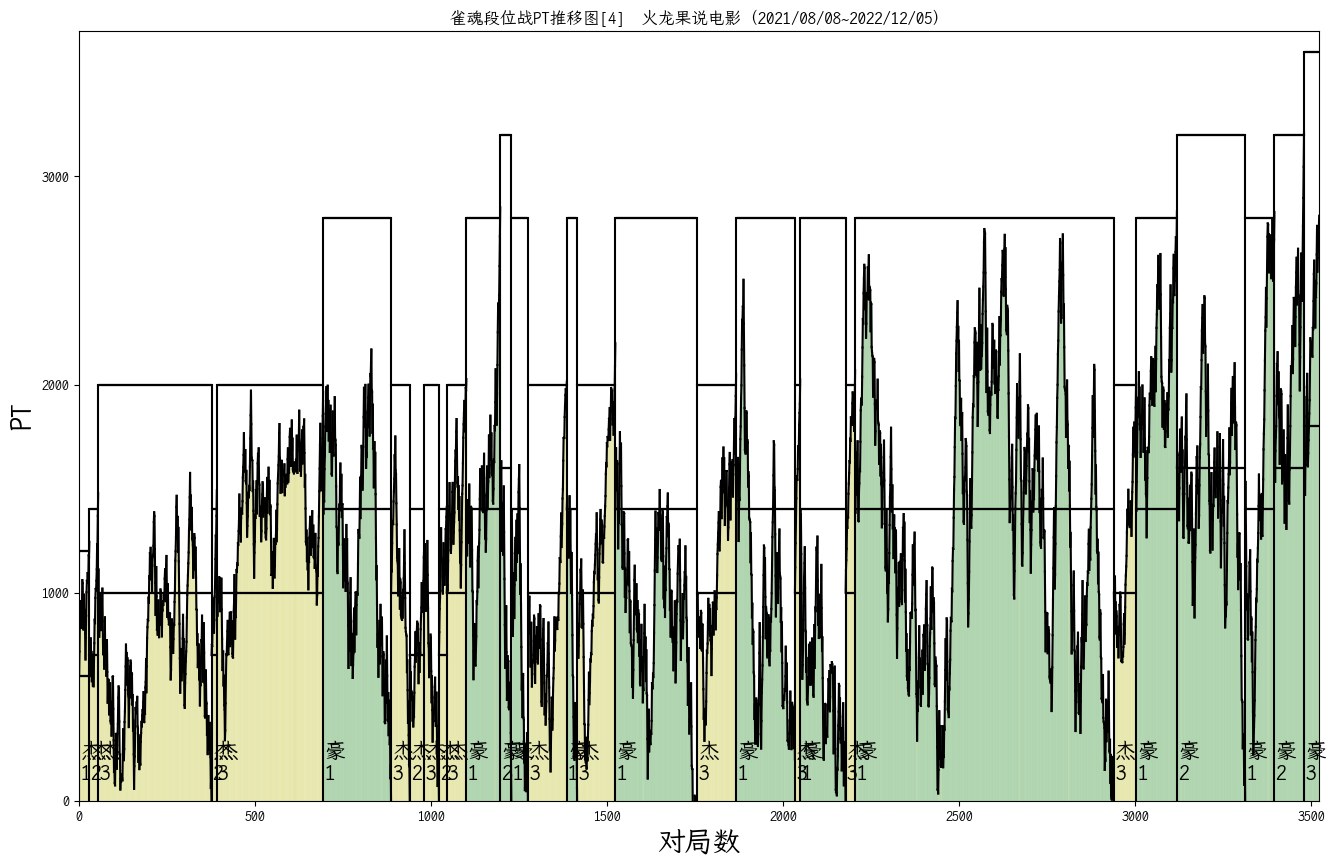

In [14]:
from datetime import datetime, timezone
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig: Figure = plt.figure(facecolor='w', figsize=(16, 10))
ax: Axes = fig.add_subplot(1, 1, 1)

pre_rank = None
pre_pt, pt, base = 0, 0, 0
max_rank = None

for i, r in enumerate(records):
    for p in r["players"]:
        if p["accountId"] != player["id"]:
            continue

        rank = p["level"]
        if max_rank is None or rank > max_rank:
            max_rank = rank

        if pre_rank != rank:
            ax.text(i + 3, 100, '\n'.join(map_rank(rank)), fontsize=15)
            ax.vlines(i, 0, max(rank_max_pt(rank), rank_max_pt(pre_rank) if pre_rank else 0), color='k')

            base = rank_max_pt(rank) // 2
            pt = pre_pt = base

        pt += p['gradingScore'] * 5 if rank // 100 % 100 >= 7 else p['gradingScore']

        ax.plot([i, i + 1], [pre_pt, pt], color='k', lw=1.5)
        ax.fill_between([i, i + 1], [pre_pt, pt], color=color[r['modeId']], alpha=0.05)
        ax.plot([i, i + 1], [base, base], color='k', lw=1.5)
        ax.plot([i, i + 1], [base * 2, base * 2], color='k', lw=1.5)

        pre_rank, pre_pt = rank, pt

start_time = datetime.fromtimestamp(records[0]["startTime"], timezone.utc)
end_time = datetime.fromtimestamp(records[-1]["startTime"], timezone.utc)

ax.set_title(f'雀魂段位战PT推移图[{player_num}]  '
             f'{player["nickname"]}'
             f'（{start_time.strftime("%Y/%m/%d")}~{end_time.strftime("%Y/%m/%d")}）',
             fontsize=12, pad=5)
ax.set_xlabel('对局数', fontsize=20)
ax.set_ylabel('PT', fontsize=20)

# ax.set_xticks(fontsize=20)
ax.set_yticks([i * 1000 for i in range(11)], fontsize=20)

ax.set_xlim(0, len(records))
ax.set_ylim(0, rank_max_pt(max_rank) + 100)

plt.show()